# Example: Create Population for West London

This notebook demonstrates an example workflow for creating a sample population for an area in West London. It creates agent plans for people and households. 

### Aim: 
Create a bigger and more realistic sample population automatically for the West London area called Londinium. The sample population includes various activities, personal attributes and modes; the population would be used as input for MATSim transport simulation.

- Import geographic data of Londinium.
- Activity generation model with home based tours. Expand agents with different personal attributes, activities and trips.
- Perform Data Visualization and validation. Plot the activity plan, distance and duration of population
- Export intermediate CSV tables of the population

In [1]:
import os
import numpy as np
from random import choice
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
%matplotlib inline
from shapely.geometry import Point

from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices, write_duration_benchmark, write_distance_benchmark, to_csv
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.read import load_travel_diary, read_matsim
from pam.samplers import facility
from pam.write import write_matsim

## Import geographic data of Londinium

In [2]:
# Import geographic data of west london area
network_bb_path = os.path.join("data", "network_bounding_box.geojson")
lsoas_path = os.path.join("data", "lsoas") # lsoas: lower layer super output areas 

We will start by plotting Londinium boundary

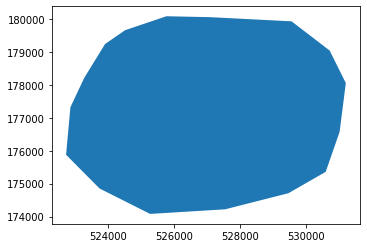

In [3]:
# Read the file and plot the boundary
boundary = gp.read_file(network_bb_path)

# Transform to epsg:27700
boundary = boundary.to_crs("epsg:27700")
boundary.plot()

Next we will plot Londinium outline shown above over a map of London to see where exactly it is located.

EPSG:27700


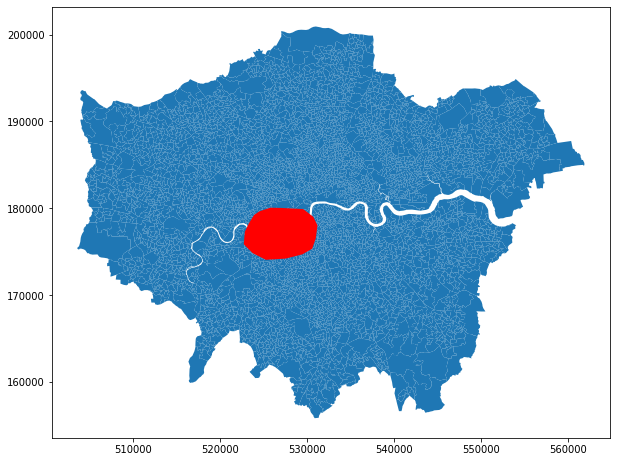

In [4]:
# Plot boundary area in lsoas
lsoas = gp.read_file(lsoas_path)
lsoas.crs = 'EPSG:27700'
print(lsoas.crs)
lsoas = lsoas.set_index("LSOA_CODE")

fig, ax = plt.subplots(figsize=(10,10))
lsoas.plot(ax = ax)
boundary.plot(ax = ax, color='red')

Finally, we will plot Londinium with LSOA boundaries included.

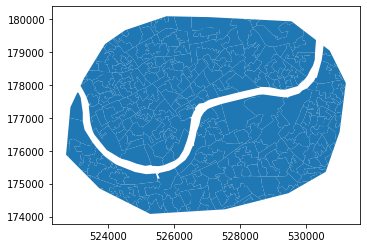

In [5]:
# Overlay the area using geopandas package
lsoas_clipped = gp.overlay(lsoas, boundary, how='intersection')
lsoas_clipped.plot()

In [6]:
lsoas_clipped.head()

,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,Hammersmith and Fulham 010A,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((523936.254 179252.052, 523932.247 17..."
1,Hammersmith and Fulham 010B,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((524142.510 179393.859, 524171.272 17..."
2,Hammersmith and Fulham 012A,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((524191.002 178908.997, 524167.660 17..."
3,Hammersmith and Fulham 012B,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((523709.779 178708.514, 523774.000 17..."
4,Hammersmith and Fulham 012C,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"MULTIPOLYGON (((524412.934 178788.791, 524422...."


In [7]:
lsoas_clipped.LA_NAME.unique()

array(['Hammersmith and Fulham', 'Kensington and Chelsea', 'Lambeth',
       'Richmond upon Thames', 'Wandsworth', 'Westminster'], dtype=object)

In [8]:
lsoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4765 entries, E01000001 to E01004765
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA_NAME   4765 non-null   object  
 1   MSOA_CODE   4765 non-null   object  
 2   MSOA_NAME   4765 non-null   object  
 3   STWARDCODE  4765 non-null   object  
 4   STWARDNAME  4765 non-null   object  
 5   LA_CODE     4765 non-null   object  
 6   LA_NAME     4765 non-null   object  
 7   geometry    4765 non-null   geometry
dtypes: geometry(1), object(7)
memory usage: 464.1+ KB


# Facility sampler

In [9]:
facilities_path = 'data/londinium_facilities_epsg_27700.geojson'
facilities = gp.read_file(facilities_path)
facilities = facilities.rename({'activities': 'activity'}, axis=1)
facilities.crs = 'EPSG:27700'

In [10]:
facilities['activity'].unique()

array(['transit', 'home', 'leisure', 'work', 'shop', 'medical',
       'education', 'park', 'other', 'pub', 'gym'], dtype=object)

Start by plotting different facility types, e.g. educational and medical facilities

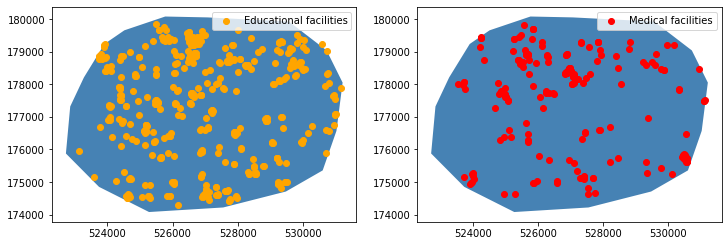

In [11]:
education = facilities[facilities['activity']=='education']
medical = facilities[facilities['activity']=='medical']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

boundary.plot(ax = ax1, color='steelblue')
education.plot(ax = ax1, color='orange', label = 'Educational facilities')
#lsoas_clipped.plot(ax = ax1)
ax1.legend()

boundary.plot(ax = ax2, color='steelblue')
medical.plot(ax = ax2, color='red', label = 'Medical facilities')
#lsoas_clipped.plot(ax = ax2)
ax2.legend()

In [12]:
# zones = lsoas_clipped
lsoas_clipped.crs = 'EPSG:27700'
len(lsoas_clipped)

306

In [13]:
lsoas_clipped = lsoas_clipped.set_index("LSOA_NAME")

In [14]:
# build the sampler
facility_sampler = facility.FacilitySampler(
    facilities=facilities,
    zones=lsoas_clipped,
    build_xml=True,
    fail=False,
    random_default=True)

Joining facilities data to zones, this may take a while.
Building sampler, this may take a while.


## Activity generation model

In [15]:
# Create random area sample
def random_area_sampler():
    indexes = list(lsoas_clipped.index)
    return np.random.choice(indexes)

random_area_sampler()  # test

'Lambeth 015E'

- It is a simple home based tours within 24 hours. 
- We create different activity types: work, leisure, education, shopping, etc. Different transport model types: car, bus, subway, etc. 
- Random number is assigned to the duration for each activity and transport mode

In [16]:
#mapping the MSOA and LAD with index
mapping_dict = dict(zip(lsoas_clipped.index, lsoas_clipped.MSOA_CODE))
mapping_dict1 = dict(zip(lsoas_clipped.index, lsoas_clipped.LA_NAME))

In [17]:
# Generate agents in west london area
def generate_agents(no_of_agents):
    """
    Randomly create agents with simple home-based tours. 
    The trip starts from home, has a random number of various acitivites, tranport modes would be added. 
    The trip finally ends at home.
    
    """
    
    population = Population() # Initialise an empty population
    
    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    sort_age = ['0 to 4', '5 to 10', '11 to 15', '16 to 20', '21 to 25', '26 to 29',
                '30 to 39', '40 to 49', '50 to 59', '60 to 64',
                '65 to 69', '70 to 74', '75 to 79', '80 to 84', '85  and over']
    
    # Create mode and activities
    transport = ['car', 'bus', 'ferry', 'rail', 'subway', 'bike', 'walk']
    # Removed gym and park due to osmox problem
    activity = ['leisure', 'work', 'shop', 'medical','education', 'park', 'pub', 'gym'] # Primary activity
    sub_activity = ["shop", "medical", "pub", "gym"] # People usually spend less time on sub activity
    
    # Add activity plan for each person
    for i in range(no_of_agents):

        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh = Household(hh_id, freq=1)
        
        # Adding Activities and Legs alternately to different agents
        # Activity 1 - home
        leaves_home = (np.random.randint(6, 8) * 60) + np.random.randint(0, 100)  # minutes
        location1 = random_area_sampler()
        location1_loc = facility_sampler.sample(location1, 'home')
        lsoa_name = mapping_dict.get(location1)
        lad_name = mapping_dict1.get(location1)

                
        agent = Person(agent_id, 
                       freq = 1,
                       attributes = {"subpopulation": np.random.choice(income) + " income",
                                     "gender" : np.random.choice(gender),
                                     "age": np.random.choice(sort_age),
                                     "household_zone": location1,
                                     "household_LSOA":lsoa_name,
                                     "household_LAD": lad_name} )
        
        
        hh.add(agent)
        population.add(hh)
        
        # Trip duration
        trip_duration_main_activity = (np.random.randint(3, 6) * 60) 
        trip_duration_sub_activity = (np.random.randint(1, 3) * 60)
        
        agent.add(Activity(
            seq = 1,
            act ='home',
            area = location1,
            loc = location1_loc,
            start_time = mtdt(0),
            end_time = mtdt(leaves_home)
        ))
    
        # Initiated parameters
        location_prev = location1
        location_prev_loc = location1_loc
        leave_time = leaves_home
    
        # Add random numbers of activities
        no_of_activities = np.random.randint(1,5)
        
        for i in range(no_of_activities):
            
            arrives_primary = leave_time + np.random.randint(10, 90)  # minutes
            
            # Activity 2.  
            if i < 2: # Start with main activity
                random_act = np.random.choice(activity)
            else: 
                random_act = np.random.choice(sub_activity)
                
            if random_act == ("work" or "education" or "leisure"):
                leaves_primary = arrives_primary + trip_duration_main_activity
            else:
                leaves_primary = arrives_primary + trip_duration_sub_activity
                
            # Outbound leg
            location_next = random_area_sampler()
            location_next_loc = facility_sampler.sample(location_next, random_act)
            
     
            agent.add(Leg(
                seq = i + 1,
                mode = np.random.choice(transport),
                start_area = location_prev,
                start_loc = location_prev_loc,
                end_area = location_next,
                end_loc = location_next_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_primary), 
            ))
    
            agent.add(Activity(
                seq = i + 2,
                act = random_act,
                area = location_next,
                loc = location_next_loc,
                start_time = mtdt(arrives_primary),
                end_time = mtdt(leaves_primary)
            ))     
        
            # Update parameters
            leave_time = leaves_primary
            location_prev = location_next
            location_prev_loc = location_next_loc
            
        
        # Inbound leg
        arrives_home = leave_time + np.random.randint(10,90)  # minutes
        agent.add(Leg(
                seq = no_of_activities + 1,
                mode = np.random.choice(transport),
                start_area = location_next,
                start_loc = location_next_loc,
                end_area = location1,
                end_loc = location1_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_home), 
            ))

        # Activity
        agent.add(Activity(
                seq = no_of_activities + 2,
                act ='home',
                area = location1,
                loc = location1_loc,
                start_time = mtdt(arrives_home),
                end_time = END_OF_DAY
            ))

    return population

In [18]:
# Create 100 agents and check the population statistics
population = generate_agents(100)
print(population.stats)

Using random sample for zone:Hammersmith and Fulham 021A:park
Using random sample for zone:Wandsworth 019C:home
Using random sample for zone:Wandsworth 011D:medical
Using random sample for zone:Wandsworth 004D:gym
Using random sample for zone:Lambeth 006E:medical
Using random sample for zone:Wandsworth 015D:pub
Using random sample for zone:Wandsworth 017E:leisure
Using random sample for zone:Wandsworth 012C:pub
Using random sample for zone:Kensington and Chelsea 011B:gym
Using random sample for zone:Kensington and Chelsea 017B:medical
Using random sample for zone:Lambeth 013E:pub
Using random sample for zone:Lambeth 015D:shop
Using random sample for zone:Hammersmith and Fulham 022D:gym
Using random sample for zone:Kensington and Chelsea 014A:park
Using random sample for zone:Lambeth 006A:shop
Using random sample for zone:Richmond upon Thames 001F:gym
Using random sample for zone:Hammersmith and Fulham 010B:medical
Using random sample for zone:Hammersmith and Fulham 012F:pub
Using rando

{'num_households': 100, 'num_people': 100, 'num_activities': 473, 'num_legs': 373}


In [19]:
population.random_person().print()

Person: agent_84
{'subpopulation': 'low income', 'gender': 'female', 'age': '65 to 69', 'household_zone': 'Kensington and Chelsea 013D', 'household_LSOA': 'E02000589', 'household_LAD': 'Kensington and Chelsea'}
0:	Activity(1 act:home, location:POINT (525597.1707406793 178809.4706723279), time:00:00:00 --> 07:14:00, duration:7:14:00)
1:	Leg(1 mode:bus, area:POINT (525597.1707406793 178809.4706723279) --> POINT (527471.1750436361 177223.6789045998), time:07:14:00 --> 08:26:00, duration:1:12:00)
2:	Activity(2 act:pub, location:POINT (527471.1750436361 177223.6789045998), time:08:26:00 --> 09:26:00, duration:1:00:00)
3:	Leg(2 mode:walk, area:POINT (527471.1750436361 177223.6789045998) --> POINT (525597.1707406793 178809.4706723279), time:09:26:00 --> 10:37:00, duration:1:11:00)
4:	Activity(3 act:home, location:POINT (525597.1707406793 178809.4706723279), time:10:37:00 --> 00:00:00, duration:13:23:00)


In [20]:
population.random_person().attributes

{'subpopulation': 'low income',
 'gender': 'female',
 'age': '85  and over',
 'household_zone': 'Hammersmith and Fulham 018E',
 'household_LSOA': 'E02000389',
 'household_LAD': 'Hammersmith and Fulham'}

## Data Visulazation and validation

In [21]:
# Validation if it works
population.validate()

In [22]:
# Print random person activity plan
population.random_person().print()

Person: agent_15
{'subpopulation': 'medium income', 'gender': 'female', 'age': '60 to 64', 'household_zone': 'Kensington and Chelsea 008B', 'household_LSOA': 'E02000584', 'household_LAD': 'Kensington and Chelsea'}
0:	Activity(1 act:home, location:POINT (525080.5018984015 179813.0648437959), time:00:00:00 --> 08:21:00, duration:8:21:00)
1:	Leg(1 mode:bus, area:POINT (525080.5018984015 179813.0648437959) --> POINT (529867.8281315549 175515.8047979805), time:08:21:00 --> 09:19:00, duration:0:58:00)
2:	Activity(2 act:shop, location:POINT (529867.8281315549 175515.8047979805), time:09:19:00 --> 10:19:00, duration:1:00:00)
3:	Leg(2 mode:rail, area:POINT (529867.8281315549 175515.8047979805) --> POINT (526556.6223816901 177504.4321259402), time:10:19:00 --> 10:48:00, duration:0:29:00)
4:	Activity(3 act:pub, location:POINT (526556.6223816901 177504.4321259402), time:10:48:00 --> 11:48:00, duration:1:00:00)
5:	Leg(3 mode:bike, area:POINT (526556.6223816901 177504.4321259402) --> POINT (525324.1

Plot the activities as a 24-hour diary schedules for 5 randomly chosen agents

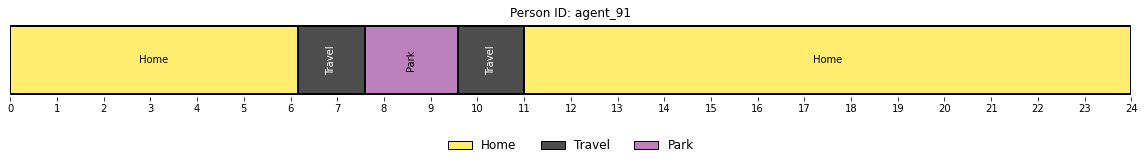

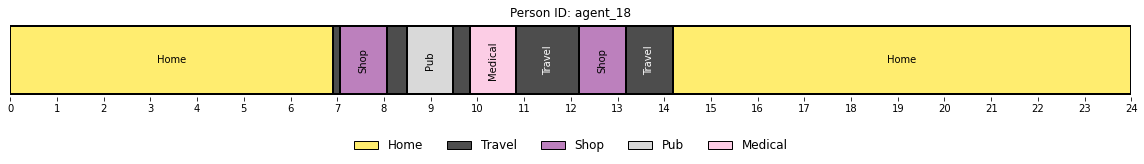

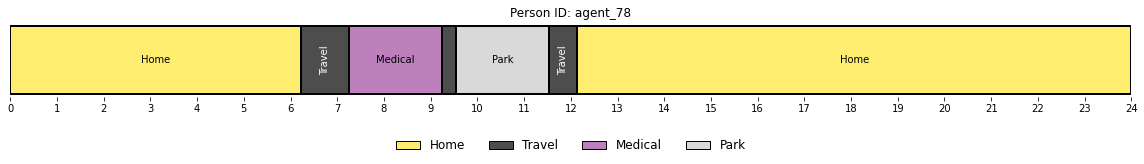

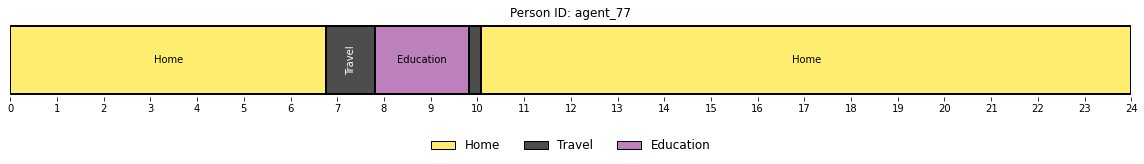

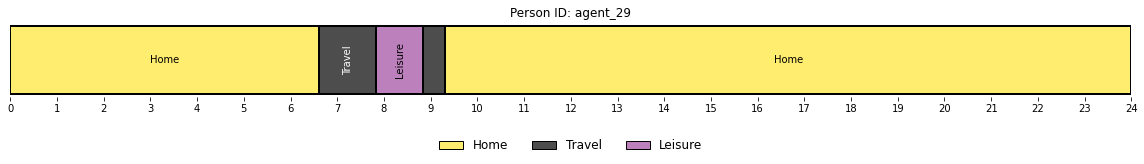

In [23]:
for i in range(5):
    p = population.random_person()
    p.plot()

Plot the frequency with which each of the activity types happens throughout the 24-hour period.

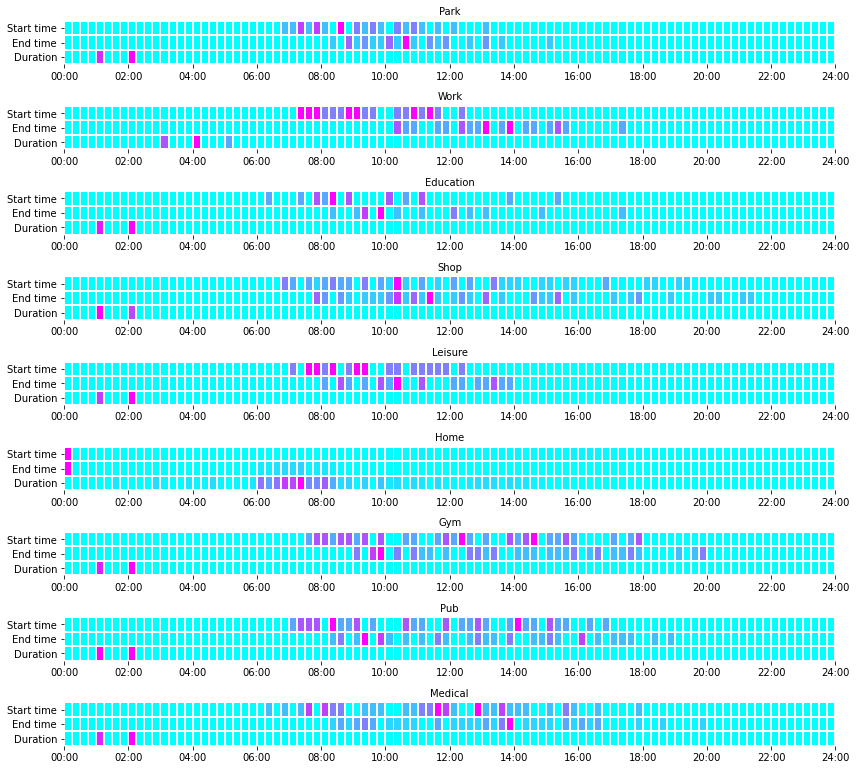

In [24]:
fig = plot_activity_times(population)

In [25]:
# Check the duration of trips
durations = write_duration_benchmark(population)
durations

,duration,trips
0,0 to 5 min,0
1,5 to 10 min,8
2,10 to 15 min,17
3,15 to 30 min,74
4,30 to 45 min,71
5,45 to 60 min,75
6,60 to 90 min,128
7,90 to 120 min,0
8,120+ min,0


Now plot a histogram for duration of the trips.

(-0.8400000000000001, 7.0)

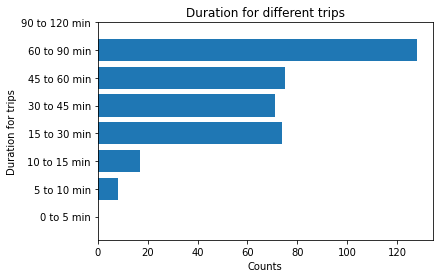

In [26]:
plt.barh(durations["duration"], durations["trips"])
plt.xlabel("Counts")
plt.ylabel("Duration for trips")
plt.title("Duration for different trips")
plt.ylim(ymax = "90 to 120 min")

In [27]:
# Check the distance of trips
distances  = write_distance_benchmark(population)
distances

,distance,trips
0,0 to 1 km,23
1,1 to 5 km,261
2,5 to 10 km,89
3,10 to 25 km,0
4,25 to 50 km,0
5,50 to 100 km,0
6,100 to 200 km,0
7,200+ km,0


Next we plot the distribution of trip distances.

(-0.79, 4.0)

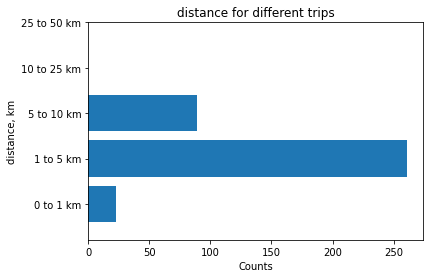

In [28]:
plt.barh(distances["distance"], distances["trips"])
plt.xlabel("Counts")
plt.ylabel("distance, km")
plt.title("distance for different trips")
plt.ylim(ymax = "25 to 50 km")

## Export intermediate CSV tables of population

In [29]:
to_csv(population, dir = "outputs", crs = "epsg:27700")

Plot the distribution of activities by type

Text(0.5, 1.0, 'activities count')

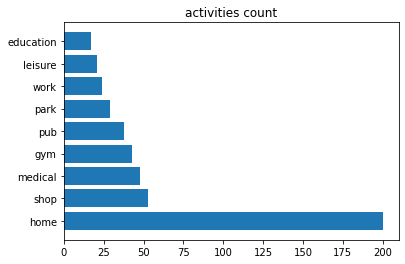

In [30]:
df_activity = pd.read_csv(os.path.join("outputs", "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")

In [31]:
write_od_matrices(population, path = "outputs")
od_matrices = pd.read_csv(os.path.join("outputs", "total_od.csv"))  # we should change this method to be consistent with other - ie return a dataframe
od_matrices["total origins"] = od_matrices.drop("Origin", axis=1).sum(axis=1)
od_matrices

,Origin,Hammersmith and Fulham 010A,Hammersmith and Fulham 010B,Hammersmith and Fulham 010D,Hammersmith and Fulham 010E,Hammersmith and Fulham 012A,Hammersmith and Fulham 012B,Hammersmith and Fulham 012C,Hammersmith and Fulham 012D,Hammersmith and Fulham 012E,...,Westminster 021A,Westminster 021C,Westminster 021E,Westminster 022A,Westminster 022B,Westminster 023B,Westminster 024A,Westminster 024C,Westminster 024D,total origins
0,Hammersmith and Fulham 010A,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,Hammersmith and Fulham 010B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,Hammersmith and Fulham 010D,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Hammersmith and Fulham 010E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Hammersmith and Fulham 012A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Westminster 022B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
209,Westminster 023B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
210,Westminster 024A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211,Westminster 024C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


Plot the number of trips originating from each LSOA

Text(0.5, 1.0, 'Total Origins')

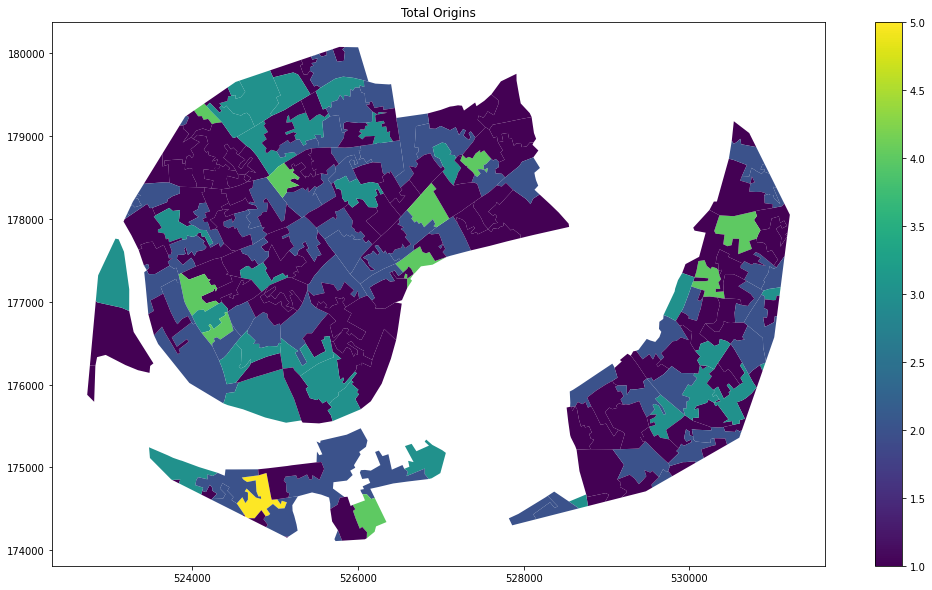

In [32]:
lsoas_clipped = lsoas_clipped.reset_index()
origins_heat_map = lsoas_clipped.join(od_matrices["total origins"])

fig, ax = plt.subplots(figsize=(18,10))    
origins_heat_map.plot("total origins", legend=True, ax=ax)
ax.set_title("Total Origins")

# Reload Tabular Data

We load in the csv files we previously wrote to disk. This replicates a simple synthesis process we might typically use for travel diary survey data.

In [33]:
people = pd.read_csv(os.path.join("outputs", "people.csv")).set_index('pid')
hhs = pd.read_csv(os.path.join("outputs", "households.csv")).set_index('hid')
trips = pd.read_csv(os.path.join("outputs", "legs.csv")).drop(['Unnamed: 0'],axis=1)

trips.rename(columns={'origin activity': 'oact', 'destination activity': 'dact'}, inplace=True)
trips.head()

,pid,hid,freq,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration
0,agent_0,hh_0,NaN,Westminster 024A,Hammersmith and Fulham 021A,NaN,home,park,ferry,1,1900-01-01 07:11:00,1900-01-01 07:22:00,0:11:00
1,agent_0,hh_0,NaN,Hammersmith and Fulham 021A,Hammersmith and Fulham 015B,NaN,park,shop,walk,2,1900-01-01 09:22:00,1900-01-01 10:20:00,0:58:00
2,agent_0,hh_0,NaN,Hammersmith and Fulham 015B,Kensington and Chelsea 012A,NaN,shop,shop,walk,3,1900-01-01 12:20:00,1900-01-01 12:38:00,0:18:00
3,agent_0,hh_0,NaN,Kensington and Chelsea 012A,Westminster 024A,NaN,shop,home,bus,4,1900-01-01 14:38:00,1900-01-01 15:16:00,0:38:00
4,agent_1,hh_1,NaN,Kensington and Chelsea 009A,Hammersmith and Fulham 021F,NaN,home,shop,bike,1,1900-01-01 07:19:00,1900-01-01 08:48:00,1:29:00


In [34]:
population_reloaded = load_travel_diary(
    trips=trips,
    persons_attributes=people,
    hhs_attributes=hhs,
)

Using from-to activity parser using 'oact' and 'dact' columns


Plot the activities as a 24-hour diary schedules

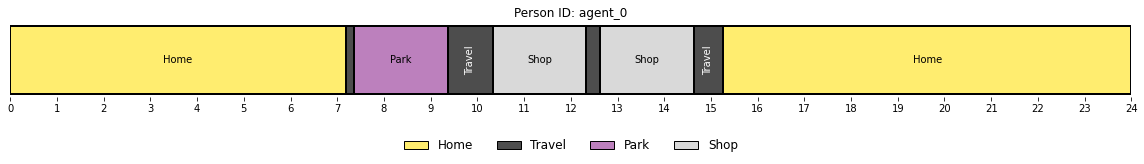

In [35]:
population["hh_0"]["agent_0"].plot()

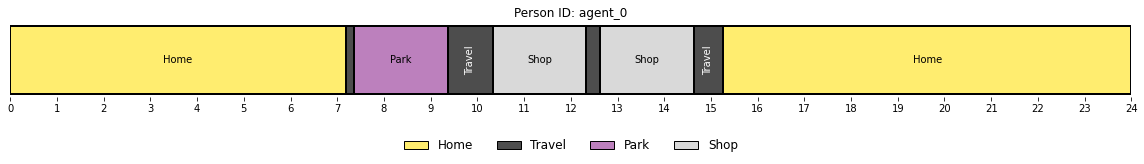

In [36]:
population_reloaded["hh_0"]["agent_0"].plot()

In [37]:
population == population_reloaded

False

The populations are not the same because the csv files did not preserve the coordinates that we previously sampled, so we will sample them again. But the reloaded population will be different as for each location a new coordinate is sampled.

# Write output to MATSim xml

In [38]:
write_matsim(population=population, plans_path=os.path.join("outputs", "population.xml"), version=12)

In [39]:
population_reloaded = read_matsim(
    plans_path=os.path.join("outputs", "population.xml"),
    household_key="hid",
    version=12
)